# <p style="background-color:brown; font-family:newtimeroman; font-size:250%; text-align:center; border-radius: 15px 50px;">Readability.</p>

# <p style="background-color:green; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;">Readability is a measure of how easy a piece of text is to read.</p>

In [ ]:
import re
import os
import numpy as np
import pandas as pd
import random as rn
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()
from plotly.offline import init_notebook_mode, iplot 
import plotly.graph_objs as go
import plotly.offline as py
import pycountry
py.init_notebook_mode(connected=True)
import folium 
from folium import plugins

#for q-q plot
from matplotlib import pyplot
from statsmodels.graphics.gofplots import qqplot
import warnings
warnings.filterwarnings("ignore")



#vis
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.manifold import TSNE
from scipy import sparse

#Modeling
import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim
from math import sqrt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
import warnings
warnings.simplefilter('ignore')

from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

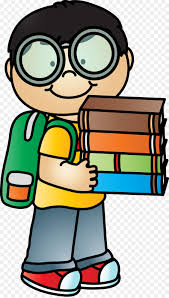

# <p style="background-color:blue; font-family:newtimeroman; font-size:150%; text-align:Right; border-radius: 15px 50px;">Let's come we start.</p>

# <p style="background-color:red; font-family:newtimeroman; font-size:100%; text-align:Left; border-radius: 15px 50px;">Helper Function.</p>

In [ ]:
train=pd.read_csv("../input/commonlitreadabilityprize/train.csv")
test=pd.read_csv('../input/commonlitreadabilityprize/test.csv')
sub=pd.read_csv("../input/commonlitreadabilityprize/sample_submission.csv")
def get_dataset_information(df):
    '''
    Take a first view of dataset
    '''
    print("Number of Columns in dataset:",df.shape[1])
    print("Number of Rows in dataset:",df.shape[0])
    print("Name of Columns in dataset:",df.columns)
    print(df.describe())
    print(df.info())
    return df.head(5)

def calculate_missing_percentage(df):
    ''' calculate missing percentage in data and stored as missing_stat
    Input: Give dataset, in which you like to check missing values
    '''
    missing_stat=df.isnull().sum()/len(df)*100
    #convert missing_stat into dataframe
    prod_count = pd.DataFrame(missing_stat.sort_index())
    plt.figure()
    #plot in barplot
    sns.barplot(x=missing_stat.index, y=missing_stat.values, alpha=0.8)
    plt.title('Percent Missing')
    plt.ylabel('Missing', fontsize=12)
    plt.xlabel('Features', fontsize=12)
    plt.xticks(rotation=90)
    plt.show()
    
def draw_num_plot(df,column,col):
    '''Draw KDE plot for given dataset and particular column
    Inputs: Pass dataframe and particular column and also pass color for making interactive map
    '''
    plt.figure(figsize=(15,8))
    mean=df[column].mean()
    median=df[column].median()
    sns.axes_style("dark")
    ax=sns.kdeplot(data=df, x=column,fill=True,color=col)
    ax.axvline(mean, color='crimson', linestyle='dotted')
    ax.axvline(median, color='g', linestyle='-')
    plt.legend({'Mean':mean,'Median':median})
    plt.show()
    

def q_q_plot(df,column):
    '''Check data column follow normal distribution or not by using Q-Q plot
    '''
    data = df[column]
    # q-q plot
    plt.figure(figsize=(15,8))
    qqplot(data, line='s')
    
    plt.show()

def draw_correlation_matrix(df):
    plt.figure(figsize=(18,6))
    #find correlation between data columns
    corrMatrix = df.corr()
    #plot by using heatmap
    sns.heatmap(corrMatrix,annot = True, vmin=-1, vmax=1, center= 0)
    plt.show()
    

def rmse_score(yreal, yhat):
    return sqrt(mean_squared_error(yreal, yhat))

# <p style="background-color:blue; font-family:newtimeroman; font-size:100%; text-align:Left; border-radius: 15px 50px;">Takes a short view about Competition.</p>
<div align='left'><font size="6" color="#F39C12">CommonLit Readability </font></div>
<hr>
<p style='text-align:justify'><b>Introduction:</b> Readability means how easily something can be read. Being easy to read is a good thing – complicated writing can make readers lose interest. Reading is an essential skill for academic success. When students have access to engaging passages offering the right level of challenge, they naturally develop reading skills.</p>

<p style='text-align:justify'><b>Objective:</b>In this competition,we will build algorithms to rate the complexity of reading passages for grade 3-12 classroom use.</p>

<p style='text-align:justify'><b>Data:</b>Let's see the Data</p>


<p style='text-align:justify'>In this competition, we have data in three files train,test and submission file</p>
<p style='text-align:justify'><b>id:  </b>unique ID for excerpt.</p>
<p style='text-align:justify'><b>url_legal:  </b>URL of source.</p>
<p style='text-align:justify'><b>license:  </b> license of source material.</p>
<p style='text-align:justify'><b>excerpt:  </b>text to predict reading ease of</p>
<p style='text-align:justify'><b>target:  </b>reading ease.</p>
<p style='text-align:justify'><b>standard_error:  </b> measure of spread of scores among multiple raters for each excerpt.</p>

<div align='left'><font size="6" color="#F39C12">Evaluation Metric</font></div>
<p style='text-align:justify'><b>RMSE  </b>Root mean squared error is a metric which we used to predict continous values. There are other metrices also used which depend on case studies problem. RMSE mostly not affect with ouliers comared to R^2 metric.</p>

<div align='left'><font size="6" color="#F39C12">Train data</font></div>

In [ ]:
train.head()

In [ ]:
get_dataset_information(train)
calculate_missing_percentage(train)

- 1. Train data have 6 columns,and we need to predict value of target column at the end of compitition.
- 2. Standard error which is defined as measure of spread of scores among multiple raters for each excerpt can see only in train data set.
- 3. Train dataset shape is (2834,6)
- 4. There are only two columns which contains missing values one is url_legal and other is license.
- 5. Missing percentage is near about 70% but still we are going to keep these features utill we perform visualization then we take a decision to keep them or discard them.

<div align='left'><font size="6" color="#F39C12">Test data</font></div>

In [ ]:
get_dataset_information(test)
calculate_missing_percentage(test)

- 1. Test data have 4 columns,target and standard_error not included in test data set.
- 2. Train dataset shape is (7,4)
- 3. There are only two columns which contains missing values one is url_legal and another is license.
- 4. Missing percentage is near about 58%.

* test set includes a slightly larger proportion of modern texts (the type of texts we want to generalize to) than the training set.

# <p style="background-color:blue; font-family:newtimeroman; font-size:150%; text-align:Left; border-radius: 15px 50px;">Explorartory Data Analysis.</p>
<div align='left'><font size="6" color="#F39C12">Target Univariate Analysis </font></div>
<hr>


In [ ]:
train['target'].describe()

- 1.Total number of target are 2834 having mean -0.95 and std_dev 1.03

In [ ]:
draw_num_plot(train,'target','blue')
q_q_plot(train,'target')

- 1.On an average our target score lies near -0.9.
- 2.According to Q-Q plot Target follow normal distribution.

<div align='left'><font size="6" color="#F39C12">Standard_error Univariate Analysis </font></div>
<hr>

In [ ]:
train['standard_error'].describe()

- 1. standard error measure of spread of scores among multiple raters for each excerpt.
- 2. standard_error having mean 0.5 and std 0.03
- 3. Interesting point to note that standard error have min value is 0 means for some excerpt did not show their interest.

In [ ]:
draw_num_plot(train,'standard_error','red')
q_q_plot(train,'standard_error')

- 1. standard error curve is having high peak compared to target curve,median of standard_error is less less than the mean of standard_error i.e. it is positively skewed whereas this is vice versa in case of target which is negatively skewed.
- 2. Q-Q plot not indicating that it follow normal distribution

* After performing univariate analysis for target and standard error,let's perform bivariate analyis for both and check the relationship between them.

In [ ]:
draw_correlation_matrix(train)

* Target and standard_error do not have much strong correlation between them.

In [ ]:
x1 = train['target'].value_counts().index.values
x2 = train['standard_error'].value_counts().index.values
sns.jointplot(x=x1,y=x2,data=train,kind='reg',color='crimson')

<div align='left'><font size="6" color="#F39C12">Let's check relationship between Excerpt and target column. </font></div>
<hr>

In [ ]:
import plotly.graph_objects as go
from fastcore.all import *
#let's see the extract which have maximum score in target and also see which one have min score in target
_max_target=pd.DataFrame(train[train['target']==train['target'].max()])
_min_target=pd.DataFrame(train[train['target']==train['target'].min()])
_zero_target=pd.DataFrame(train[train['target']==0])
def look_at_text(df):
    fig = go.Figure(data=[go.Table(
        columnwidth = [200,600],
        header=dict(values=['Excerpt('+str(df['target'].values[0])+')'],
                    line_color='darkslategray',
                    fill_color='darkblue',
                    align='left',  
                    font=dict(color='white', size=16)
                   ),
        cells=dict(values=df['excerpt'].T, 
                   line_color='darkslategray',
                   fill_color=['lightgray','white'],
                   align='left'))
    ])
    dslabel   = df['excerpt'].iloc[0]
    fig.update_layout(width=1000, height=350)
    fig.update_layout(title=go.layout.Title(text="Excerpt with target", font=dict(
                family="Courier New, monospace",
                size=22,
                color="#0000FF"
            )))
    fig.show()
look_at_text(_min_target)
look_at_text(_zero_target)
look_at_text(_max_target)

1. So target values lies between -3.67 and 1.71138, min value of target represent that excerpt is not easy to read where as maximum value represent that excerpt can be read easily with flow.
2. We have target with 0 value also i.e. that excerpt is basseline to compare with other excerpt,excerpt getting zero score means someone can read and someone cannot read.

Have you read all three?

<div align='Left'><font size="6" color="#F39C12">Excerpt</font></div>
<hr>
1. Excerpt is a piece of text from which we need to measure readibility.

2. There are total number of excerpt 2834 in training data set and all are the uniques excerpt

In [ ]:
train['excerpt'].describe()

In [ ]:
from wordcloud import WordCloud

# Thanks : https://www.kaggle.com/aashita/word-clouds-of-various-shapes ##
def plot_wordcloud(text, mask=None, max_words=1000, max_font_size=100, figure_size=(14.0,16.0), 
                   title = None, title_size=40, image_color=False):
    

    wordcloud = WordCloud(background_color='black',max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=800, 
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  
    
plot_wordcloud(train["excerpt"], title="Word Cloud of Excerpt")

<div align='left'><font size="6" color="#F39C12">Generate some Meta Features</font></div>
<hr>
<p style='text-align:justify'><b>Meta Features:</b>Let's generate some meta features before applyting text cleaning as there maybe some features exist in meta data which can help us to build some features and they can help us in predicting scores</p>

In [ ]:
train_data=train.copy()
test=pd.read_csv('../input/commonlitreadabilityprize/test.csv')
test_data=test.copy()

In [ ]:


from wordcloud import WordCloud, STOPWORDS
import string

#Let's extract some meta data to undeerstand more about target relation with text
## Number of words in the text ##
train["num_words"] = train["excerpt"].apply(lambda x: len(str(x).split()))
test["num_words"] = test["excerpt"].apply(lambda x: len(str(x).split()))

## Number of unique words in the text ##
train["num_unique_words"] = train["excerpt"].apply(lambda x: len(set(str(x).split())))
test["num_unique_words"] = test["excerpt"].apply(lambda x: len(set(str(x).split())))

## Number of characters in the text ##
train["num_chars"] = train["excerpt"].apply(lambda x: len(str(x)))
test["num_chars"] = test["excerpt"].apply(lambda x: len(str(x)))

## Number of stopwords in the text ##
train["num_stopwords"] = train["excerpt"].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
test["num_stopwords"] = test["excerpt"].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

## Number of punctuations in the text ##
train["num_punctuations"] =train['excerpt'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )
test["num_punctuations"] =test['excerpt'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )

## Number of title case words in the text ##
train["num_words_upper"] = train["excerpt"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
test["num_words_upper"] = test["excerpt"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

## Number of title case words in the text ##
train["num_words_title"] = train["excerpt"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
test["num_words_title"] = test["excerpt"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

## Average length of the words in the text ##
train["mean_word_len"] = train["excerpt"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test["mean_word_len"] = test["excerpt"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

In [ ]:
#let's look at train data 
train.head(3)

Some Meta features we generate bu using simple operations.
1. num_words: Number of words are in excerpt
2. num_unique_words: How many unique words come in throughout excerpt
3. num_chars: Number of characters in excerpt
4. num_stopwords: How many stopwords are exist?.In NLP stopwords have there own importance, many times feature will help us to boost our score and that the region we extract it.
5. num_punctuations: Number of Punctuation in excerpt
6. num_words_upper: How many words have upper word in excerpt
7. num_words_title: How many titles are exist
8. mean_word_len: Calculate average length of excerpt

In [ ]:
def kde_plot(meta_data):
    plt.figure(figsize=(12,6))
    p1=sns.kdeplot(train[meta_data], shade=True, color="darkred").set_title('Kernel Distribution of '+ meta_data)
    #p1=sns.kdeplot(test[meta_data], shade=True, color="red")
    plt.legend(labels=['Train','Test'])
    
#plot all the meta data
col_list=train.columns[6::]
for i in range(len(col_list)):
    kde_plot(col_list[i])

Conclusion of EDA on meta data:

1. In train data most of extract contains 135 to 175 num_of_words.
2. Num of unique words in train data lies between 75 to 160
3. Num of characters much more look like follow normal distribution.
4. Training data is more skewed in case of num of punctuation,upper number of words ,title, and average len of words.

In [ ]:
draw_correlation_matrix(train)

<div align='Left'><font size="6" color="#F39C12">Data Cleaning</font></div>

1. Make extract lower case and remove next line 

2. use tokenization

3. remove punctuation

4. remove stopwords

In [ ]:
train_data=train.copy()
import string
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
def preprocess_text(text):
    text=str(text).lower()
    text = re.sub('\n', '', text)
    return text

def removestop(text):
    stop_words = set(stopwords.words('english')) 
  
    word_tokens = word_tokenize(text) 
    filtered_sentence = [w for w in word_tokens if not w in stop_words] 
    filtered_sentence = [] 
  
    for w in word_tokens: 
        if w not in stop_words: 
            filtered_sentence.append(w) 
    return filtered_sentence
STOP_WORDS = set(stopwords.words('english')) # stop words
def rem_stop(text):
    text = ' '.join([i for i in text.split() if i not in STOP_WORDS])
    return text
def remove_punctuation(text):
    text_clean="".join([i for i in text if i not in string.punctuation])
    return text_clean

train_data['excerpt']=train_data['excerpt'].apply(lambda x:remove_punctuation(x))
train_data['excerpt']=train_data['excerpt'].apply(lambda x:preprocess_text(x))
train_data['excerpt']=train_data['excerpt'].apply(lambda x:removestop(x))

In [ ]:
from collections import Counter
def find_common_words_and_count(dataframe,col_name):
    dataframe['temp_list'] = dataframe[col_name].apply(lambda x:str(x).split())
    top = Counter([item for sublist in dataframe[col_name] for item in sublist])
    temp = pd.DataFrame(top.most_common(50))
    temp.columns = ['Common_words','count']
    temp.style.background_gradient(cmap='Green')
    return temp

import plotly.express as px
fig = px.bar(find_common_words_and_count(train_data,'excerpt'), x="count", y="Common_words", title='Commmon Words in Excerpt', orientation='h', 
             width=1000, height=700,color='Common_words')
fig.show()

fig = px.treemap(find_common_words_and_count(train_data,'excerpt'), path=['Common_words'], values='count',title='Tree of Most Common Words')
fig.show()

- .In both the above charts we can understand that which kind of words excerpt contains. 

<div align='Left'><font size="6" color="#F39C12">License</font></div>
<hr>

In [ ]:
from plotly.offline import init_notebook_mode, iplot 
trace1 = go.Bar(
                    y=train['license'].value_counts().index,
                    x =train['license'].value_counts(sort=True).values,
                    orientation='h',
                    marker = dict(color='green',
                                 line=dict(color='skyblue',width=1)),
                    text = train.index)
data = [trace1]
layout = go.Layout(barmode = "group",title="license",width=800, height=500, 
                       xaxis= dict(title="license"),
                       yaxis=dict(autorange="reversed"),
                       showlegend=False)
fig = go.Figure(data = data, layout = layout)
iplot(fig)

- First this data column have missing values near 70% and this does not looking like it adding some kind of useful information

<div align='Left'><font size="6" color="#F39C12">URL</font></div>
- URL also have near about 70% data is missing but we maybe can extract some useful information from it.So Let's keep it in our columns bucket

In [ ]:
import warnings
train['url_legal']=train['url_legal'].fillna("Missing_source")
train['source_type']=''
train['website']=''
for i in range(len(train)):
    if train['url_legal'][i]=='Missing_source':
        train['source_type'][i]='Missing_source'
        train['website'][i]='Missing_source'
    elif train['url_legal'][i]!='Missing_source':
        list_source=train['url_legal'].apply(lambda x: x.split('/'))[i][2:]
        train['source_type'][i]=list_source[1]
        web=train['url_legal'].apply(lambda x: x.split('/'))[i][2:]
        train['website'][i]=web[0]

In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fi = make_subplots(
    rows=2, cols=2,subplot_titles=('source_type','website')
)

fi.add_trace(go.Bar(x=train['source_type'].value_counts().index, y=train['source_type'].value_counts().values,
                    marker=dict(color=[4, 5, 6], coloraxis="coloraxis")),
              1, 1)

fi.add_trace(go.Bar(x=train['website'].value_counts().index, y=train['website'].value_counts().values,
                    marker=dict(color=[2, 3, 5], coloraxis="coloraxis")),
              1, 2)

fi.update_layout(coloraxis=dict(colorscale='Bluered_r'),height=500, showlegend=False)

source_type = train['source_type'].value_counts().reset_index()
website = train['website'].value_counts().reset_index()

pie_men = go.Pie(labels=source_type['index'],values=source_type['source_type'],name='source_type',hole=0.8,domain={'x': [0,0.56]})

pie_women = go.Pie(labels=website['index'],values=website['website'],name="website",hole=0.8,domain={'x': [0.52,1]})

layout = dict(title = 'Features_Extraction_from_URL', font=dict(size=10), legend=dict(orientation="h"),
              annotations = [dict(x=0.2, y=0.5, text='source_type', showarrow=False, font=dict(size=20)),
                             dict(x=0.8, y=0.5, text='website', showarrow=False, font=dict(size=20)) ])

fig = dict(data=[pie_men, pie_women], layout=layout)
py.iplot(fig)
fi.show()



<div align='Left'><font size="6" color="#F39C12">Modeling</font></div>

-  After perform exploratory data analysis and visualization,Now we can start our work regrading Modeling.
-  I want to keep this notebook as simple as it is, so let's start from Machine learning Algorithm inplace of directly using Bert and cutting edge techniques in Natural language Processing.
- Let's see in this below section how we can apply algorithms and generate results.

- Keeping some points in mind below, we will start.
      - Split dataset randomly by using train_test_split
      - Use TF-IDF with Word2vector
      - Standarized numerical features
      - GridSearchCV and RandomsearchCV
      - fit the model,predict and submit it.

In [ ]:
import string
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
def preprocess_text(text):
    text=str(text).lower()
    text = re.sub('\n', '', text)
    return text

STOP_WORDS = set(stopwords.words('english')) # stop words
def rem_stop(text):
    text = ' '.join([i for i in text.split() if i not in STOP_WORDS])
    return text
def remove_punctuation(text):
    text_clean="".join([i for i in text if i not in string.punctuation])
    return text_clean

train['excerpt']=train['excerpt'].apply(lambda x:remove_punctuation(x))
train['excerpt']=train['excerpt'].apply(lambda x:preprocess_text(x))
train['excerpt']=train['excerpt'].apply(lambda x:rem_stop(x))

test['excerpt']=test['excerpt'].apply(lambda x:remove_punctuation(x))
test['excerpt']=test['excerpt'].apply(lambda x:preprocess_text(x))
test['excerpt']=test['excerpt'].apply(lambda x:rem_stop(x))

In [ ]:
import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim

1. Below I wrote a function which calculate TF-IDF_W2V
2. Load GoogleNews-vectors by using genism
3. Standarized numerical fetaures.

In [ ]:
def TF_IDF_W2V(text):
    '''Calculate TF-IDF with word2vec
    '''
    #Load TF-IDF from sklearn
    TFIDF_model = TfidfVectorizer()
    #fit on text
    TFIDF_model.fit(text)
    #create dictionary with word as key
    #and idf as value
    dictionary = dict(zip(TFIDF_model.get_feature_names(), list(TFIDF_model.idf_)))
    #apply set as we need unique features
    TFIDF_words = set(TFIDF_model.get_feature_names())
    #create list which stores TFIDF_W2V
    TFIDF_W2V_vectors = []
    for sentence in text:
        #create empty vector to store result
        vector = np.zeros(300)
        #number of words with valid vector in sentence
        TFIDF_weight =0
        for word in sentence.split(): 
            #if word exist in glove_words and TFIDF_words
            if (word in glove_words) and (word in TFIDF_words):
                #get its vector from glove_words
                vec = word2vec_model[word]
                #calculate TF-IDF for each word
                TFIDF = dictionary[word]*(sentence.count(word)/len(sentence.split()))
                #calculate TF-IDF weighted W2V
                vector += (vec * TFIDF)
                TFIDF_weight += TFIDF
                
        if TFIDF_weight != 0:
            vector /= TFIDF_weight
        TFIDF_W2V_vectors.append(vector)
    return TFIDF_W2V_vectors 

In [ ]:
word2vec_model = gensim.models.KeyedVectors.load_word2vec_format('../input/googlenewsvectorsnegative300/GoogleNews-vectors-negative300.bin', binary=True)
print(word2vec_model.vectors.shape)

In [ ]:
glove_words = list(word2vec_model.index_to_key)

In [ ]:
tfidf_w2v_excerpt_train = TF_IDF_W2V(train['excerpt'])
tfidf_w2v_excerpt_test = TF_IDF_W2V(test['excerpt'])

In [ ]:
#standarized the numerical_feature 
x_train_ = StandardScaler().fit_transform(train[['num_words', 'num_unique_words', 'num_chars', 'num_stopwords',
       'num_punctuations', 'num_words_upper', 'num_words_title',
       'mean_word_len']])
x_test_ = StandardScaler().fit_transform(test[['num_words', 'num_unique_words', 'num_chars', 'num_stopwords',
       'num_punctuations', 'num_words_upper', 'num_words_title',
       'mean_word_len']])
print("Standardizing numerical features")

In [ ]:
df1_test=pd.DataFrame(tfidf_w2v_excerpt_test)
df2_test=pd.DataFrame(x_test_)

df1=pd.DataFrame(tfidf_w2v_excerpt_train)
df2=pd.DataFrame(x_train_)

df1['id']=train['id']
df2['id']=train['id']

df1_test['id']=test['id']
df2_test['id']=test['id']

result=df1.merge(df2,on='id')
result_test=df1_test.merge(df2_test,on='id')

result_test.drop('id',axis=1,inplace=True)
result.drop('id',axis=1,inplace=True)

y_true=train['target']

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test, y_train, y_test = train_test_split(result, y_true, test_size=0.1)

<div align='Left'><font size="6" color="#F39C12">Linear Regression</font></div>

In [ ]:
#hyper-paramater tuning
clf = SGDRegressor(loss = "squared_loss", penalty = "l2")
values = [10**-14, 10**-12, 10**-10, 10**-8, 10**-6, 10**-4, 10**-2, 10**0, 10**2, 10**4, 10**6]
hyper_parameter = {"alpha": values}
best_parameter = GridSearchCV(clf, hyper_parameter, scoring = "neg_mean_absolute_error", cv = 3)
best_parameter.fit(X_train, y_train)
alpha = best_parameter.best_params_["alpha"]
    
#applying linear regression with best hyper-parameter
clf = SGDRegressor(loss = "squared_loss", penalty = "l2", alpha = alpha)
clf.fit(X_train, y_train)
train_pred = clf.predict(X_train)
train_RMSE_lr = rmse_score(y_train, train_pred)
val_pred = clf.predict(X_test)
val_RMSE_lr = rmse_score(y_test, val_pred)

print("linear_regression_score:",train_RMSE_lr,val_RMSE_lr)

<div align='Left'><font size="6" color="#F39C12">XG_Boost</font></div>

In [ ]:
#load model
clf = xgb.XGBRegressor()
#set the hyperparamters in form of dict
hyper_parameter = {"max_depth":[1,3,5,7], "n_estimators":[100,150,200,250]}
#Use RandomizedSearchCV
best_parameter = RandomizedSearchCV(clf, hyper_parameter, scoring = "neg_mean_absolute_error", cv = 5)
#fit on training data
best_parameter.fit(X_train, y_train)
#get best estimators
estimators = best_parameter.best_params_["n_estimators"]
#best depth
depth = best_parameter.best_params_["max_depth"]

In [ ]:
#applying xgboost regressor with best hyper-parameter
clf = xgb.XGBRegressor(max_depth =depth, n_estimators =estimators)
clf.fit(X_train, y_train)
#predict on X_train
train_pred = clf.predict(X_train)
#calculate RMSE
train_RMSE_Xg = rmse_score(y_train, train_pred)
#Predict on validation set
val_pred = clf.predict(X_test)
#calculate RMSE
val_RMSE_Xg = rmse_score(y_test, val_pred)

print("XG_regression_score:",train_RMSE_Xg,val_RMSE_Xg)

<div align='Left'><font size="6" color="#F39C12"></font></div>

In [ ]:
'''
from sklearn.svm import SVR
parameters = {'kernel': ('linear', 'rbf','poly'), 'C':[1.5, 10],'gamma': [1e-7, 1e-4],'epsilon':[0.1,0.2,0.5,0.3]}
clf = SVR()
best_parameter = GridSearchCV(clf, parameters,scoring = "neg_mean_absolute_error", cv = 7)
best_parameter.fit(X_train, y_train)
best_parameter.best_params_
clf = SVR(kernel='linear', C=1.5, gamma=1e-07,epsilon= 0.3)
clf.fit(X_train, y_train)
train_pred = clf.predict(X_train)
train_RMSE_SV = rmse_score(y_train, train_pred)
val_pred = clf.predict(X_test)
val_RMSE_SV = rmse_score(y_test, val_pred)

print("SVM_regression_score:",train_RMSE_SV,val_RMSE_SV)
'''

In [ ]:
submission = pd.read_csv('../input/commonlitreadabilityprize/sample_submission.csv')
d_test = clf.predict(result_test)

submission['target'] = d_test
submission.to_csv('submission.csv', index=False)